
## Generalized Advantage Estimation in Reinforcement Learning

### References:
[1] Schulman, J., Moritz, P., Levine, S., Jordan, M., & Abbeel, P. (2015). High-dimensional continuous control using generalized advantage estimation. arXiv preprint arXiv:1506.02438.


The code in this notebook demo is adapted based on - https://colab.research.google.com/drive/1Wb_2zKgAqhI2tVK19Y1QC8AHImrzlcme?usp=sharing


#### **Problem Setting**

In this notebook, we consider a typical formulation of the policy optimization problem. The initial state $s_0$ is sampled from initial distribution $p_0$. A trajectory $(s_0, a_0, s_1, s_0, ...)$ is generated by sampling from policy $\pi(a_t|s_t)$. The states then transition from $s_t$ to $s_{t+1}$ from a sampled distribution of $P(s_{t+1}|s_t, a_t)$. A reward $r_t = r(s_t, a_t, s_{t+1})$ is dispensed at each time stamp. The goal is to maximize the expected total reward $\sum_{t=0}^{\infty}r_t$, which is assumed to be finite for all policies in this problem setting. 

Moreover, in this problem, we are not assuming a discount as part of the problem specification. It appears to be a controllable parameter that adjusts bias-variance tradeoff.

Policy gradient methods maximizes the expected total reward by estimating the policy gradient at each time stamp. The gradient which points to the direction where parameter $\theta$ in the policy term $\pi_\theta(a_t|s_t)$ is hard to be computed through a closed-form expression. We aim to demonstrate a method of estimating the policy gradient empirically through a set of trajectories.


#### **Policy Gradient**

We can be represented by

$$ g = \triangledown_{\theta} E[\sum_{t=0}^{\infty} r_t]. $$

The estimation of policy gradient through a set of trajectories is one of the most fundamental problems. In this problem settig, we assume that the policy gradient possess the following particular form:

$$ g = E[\sum_{t=0}^{\infty} A^{\pi}(s_t, a_t) \triangledown_\theta log \pi_{\theta}(a_t | s_t)], $$

where $A^{\pi}$ is the advantage of $(a_t, s_t)$ in comparisons to the average value function $V^{\pi}(s_t) = E_{s_{t+1}:\infty, a_t:\infty}[\sum_{l=0}^{\infty}r_{t+l}]$.

That is, $A^{\pi}(s_t, a_t) = Q^{\pi}(s_t, a_t) - V^{\pi}(s_t),$

where $Q^{\pi}(s_t, a_t) = E_{s_{t+1}:\infty, a_{t+1}:\infty}[\sum_{l=0}^{\infty}r_{t+l}]$. 

The difference between $Q^{\pi}(s_t, a_t)$ and $V^{\pi}(s_t)$ is that $Q^{\pi}(s_t, a_t)$ the expected return across all rollouts after taking action $a_t$ at $s_t$ whereas $V^{\pi}(s_t)$ is the expected return across all actions taken in $s_t$ resulting all subsequential rollouts. The advantage function is therefore the "advantage" of taking a specific action $a_t$ at $s_t$ in comparison to the average overall return of all actions to be taken at $s_t$.

The selection of $A^{\pi}(s_t, a_t)$ term as part of the policy gradient ensures that the gradient points in the direction of increased $\pi_{\theta}(a_t|s_t)$ if and only if $A^{\pi}(s_t, a_t) > 0$.

#### **Approximation of Policy Gradient**

We can introduce a parameter $\gamma$ in the estimation of $g$, denoted as $g^{\gamma}$, to control the bias-variance tradeoff in the estimation.

$$ g^{\gamma} = E[\sum_{t=0}^{\infty} A^{\pi, \gamma}(s_t, a_t) \triangledown_\theta log \pi_{\theta}(a_t | s_t)], $$

where $A^{\pi, \gamma}(s_t, a_t)$ is the discounted advantage function, which has form as

$$A^{\pi, \gamma}(s_t, a_t) = Q^{\pi, \gamma}(s_t, a_t) + V^{\pi, \gamma}(s_t).$$

$Q^{\pi, \gamma}(s_t, a_t), V^{\pi, \gamma}(s_t)$ are the discounted version of $Q^{\pi}(s_t, a_t), V^{\pi}(s_t)$, i.e.,

$$Q^{\pi, \gamma}(s_t, a_t) = E_{s_{t+1:\infty}, a_{t+1:\infty}}[\sum_{l=0}^\infty\gamma^l r_{t+l}]$$ 

,and

$$V^{\pi, \gamma}(s_t) = E_{s_{t+1:\infty}, a_{t:\infty}}[\sum_{l=0}^\infty\gamma^l r_{t+l}].$$


They have the exact same form as in the literature of discounted return in Reinforcement Learning. However, in this context, the purpose of the parameter $\gamma$ is to control the variability of value function at any state $s_t$ by introducing bias term.

Based on the above estimator $g^{\gamma}$, we want to estimate $g^{\gamma}$.


#### **Generalized Estimator of Advange**

The target of Generalized Estimator of Advantage is to have

$$\hat{A}_t(s_{0:\infty}, a_{0;\infty})$$

such that 

$$E_{s_0:\infty,a_0:\infty}[\sum_{t=0}^{\infty}\hat{A}_t(s_{0:\infty}, a_{0;\infty})\triangledown_\theta log \pi_{\theta}(a_t | s_t)] = E[\sum_{t=0}^{\infty} A^{\pi, \gamma}(s_t, a_t) \triangledown_\theta log \pi_{\theta}(a_t | s_t)].$$

Note that we already introduced bias to the estimation of policy gradient when we replace $A^{\pi}$ by $A^{\pi, \gamma}$. Here we only consider an unbiased estimator of $g^{\gamma}$, which is a biased estimate of policy gradient of undiscounted MDP.

Suppose that $V$ is an approximate value function, we define TD residuals $\delta_t^V = r_t + \gamma V(s_{t+1}) - V(s_t)$ where $\gamma$ is the discount factor. $\delta_t^V$ can be considered as an estimate of the advantage of the action $a_t$. If we have the correct value function $V = V^{\pi, \gamma}$, we can easily show that 

$$E_{s_{t+1}}[\delta_t^{V^{\pi, \gamma}}] = E_{s_{t+1}}[Q^{\pi,\gamma}(s_t,a_t) - V^{\pi, \gamma}(s_t)] = A^{\pi, \gamma}(s_t, a_t).$$

However, it is not unbiased estimator if $V \neq V^{\pi, \gamma}$, which means that using TD residual would introduce bias unless we know the exact value function.

Consider a general $k$ sums of these TD residuals,

$$\hat{A}_t^{(1)} = \delta_t^V = -V(s_t) + r_t + \gamma V(s_{t+1})$$
$$\hat{A}_t^{(2)} = \delta_t^V + \gamma \delta_{t+1}^V = -V(s_t) + r_t + \gamma r_{t+1} + \gamma^2 V(s_{t+1})$$
$$\hat{A}_t^{(k)} = \sum_{l=0}^{k-1} \gamma^l \delta_{t+l}^V = -V(s_t) + r_t + \gamma r_{t+1} + ... + \gamma^{k-1} r_{t+k-1} + \gamma^kV(s_{t+k})$$

An importan obervasion is that as $k$ becomes larger, the bias introduced by inaccurate value function $V$ gets smaller and smaller. As $k \rightarrow \infty$,

$$\hat{A}_t^{\infty} = \sum_{l=0}^{\infty} \gamma^l \delta_{t+l}^V = -V(s_t) + \sum_{l=0}^{\infty} \gamma^l r_{t+l}.$$

Recall that $A^{\pi, \gamma} = Q^{\pi, \gamma}(s_t,a_t) - V^{\pi, \gamma}(s_t) = E_{s_{t+1:\infty}, a_{t+1:\infty}}[\sum_{l=0}^{\infty} \gamma^l r_{t+l}] - V^{\pi, \gamma}(s_t)$.

Comparing these two above equations, we can find that taking expectation of $\hat{A}_t^{\infty}$ would result in expectation of $A^{\pi, \gamma}$, regardless of the choice of $V$ by Proposition 1 in the paper.

**Prop. 1** Suppose that $\hat{A}_t$ can be written in the form $\hat{A}_t(s_{0:\infty},a_{0:\infty}) = Q_t(s_{t:\infty}, a_{t:\infty}) - b_t(s_{0:t}, a_{0:{t-1}})$ such that for all $(s_t, a_t)$, $E_{s_{t+1:\infty},a_{t+1:\infty}}[Q_t(s_{t:\infty},a_{t:\infty})] = Q^{\pi, \gamma}(s_t, a_t). Then, E_{s_{0:\infty},a_{0:\infty}}[\hat{A}_t(s_{0:\infty},a_{0:\infty})] = E_{s_{0:\infty},a_{0:\infty}}[A^{\pi, \gamma}(s_t,a_t)]$.

To further control the bias-varaince tradeoff with estimator $A^{\infty}_t$
Therefore, an enhancement of the above estimator is to use exponentially-weighted sum of $k$-step estimator:

$$\hat{A}^{GAE(\gamma,\lambda)} = (1-\lambda)(\hat{A}^{(1)}_t + \lambda \hat{A}^{(2)}_t + ...) = \sum_{l=0}^{\infty} (\gamma \lambda)^l \delta_{t+l}^V$$

Note that when $\lambda = 0$, $\hat{A}^{GAE(\gamma,0)}$ is reduced to $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$, which as discussed above is biased unless $V = V^{\pi, \gamma}$. When $\lambda = 1$, $\hat{A}^{GAE(\gamma,0)} = A_t^{\infty}$ which has expectation equal to the expectation of $A^{\pi, \gamma}$.


**Some Transition Dynamics**

In [37]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [38]:
P = np.array([[[1, 0, 0, 0, 0, 0, 0],    # s_0 terminal \
               [1, 0, 0, 0, 0, 0, 0],    # s_1           |
               [0, 1, 0, 0, 0, 0, 0],    # s_2           |
               [0, 0, 1, 0, 0, 0, 0],    # s_3           |-> for action a_0 i.e. left          
               [0, 0, 0, 1, 0, 0, 0],    # s_4           |
               [0, 0, 0, 0, 1, 0, 0],    # s_5           |
               [0, 0, 0, 0, 0, 0, 1]],   # s_6 terminal /
              
              [[1, 0, 0, 0, 0, 0, 0],    # s_0 terminal \
               [0, 0, 1, 0, 0, 0, 0],    # s_1           |
               [0, 0, 0, 1, 0, 0, 0],    # s_2           |
               [0, 0, 0, 0, 1, 0, 0],    # s_3           |-> for action a_1 i.e. right
               [0, 0, 0, 0, 0, 1, 0],    # s_4           |
               [0, 0, 0, 0, 0, 0, 1],    # s_5           |
               [0, 0, 0, 0, 0, 0, 1]]])  # s_6 terminal /
#  State:       0  1  2  3  4  5  6

r = np.array([[0, 0],  # s_0
              [0, 0],  # s_1
              [0, 0],  # s_2
              [0, 0],  # s_3
              [0, 0],  # s_4
              [0, 1],  # s_5
              [0, 0]]) # s_6
# Action:    a_0  a_1

pi = np.array([[0.5, 0.5],  # s_0
               [0.5, 0.5],  # s_1
               [0.5, 0.5],  # s_2
               [0.5, 0.5],  # s_3
               [0.5, 0.5],  # s_4
               [0.5, 0.5],  # s_5
               [0.5, 0.5]]) # s_6
# Action:       a_0  a_1

tabular_features = np.array([[0, 0, 0, 0, 0],  # s_0 terminal
                             [1, 0, 0, 0, 0],  # s_1
                             [0, 1, 0, 0, 0],  # s_2  
                             [0, 0, 1, 0, 0],  # s_3
                             [0, 0, 0, 1, 0],  # s_4
                             [0, 0, 0, 0, 1],  # s_5
                             [0, 0, 0, 0, 0]]) # s_6 terminal

Given a linear chain, the step function will calculate the next stochastic state and reward automatically based on the action and the transition dynamics.

In [39]:
class LinearChain():
    def __init__(self, P, r, start_state, terminal_states, noise=0):
        self.P = P
        self.r = r
        self.noise = noise
        self.n = P.shape[-1]
        self.start_state = start_state
        self.terminal_states = terminal_states

        self.observation_space = self.n
        self.action_space = 2
        self.state = None

        self.t = 0

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        if self.state is None:
            raise Exception('step() used before calling reset()')
        assert action in range(P.shape[0])

        reward = r[self.state, action] \
            + np.random.normal(loc=0, scale=self.noise)
        self.state = np.random.choice(a=self.n, p=self.P[action, self.state])
        self.t = self.t + 1

        done = False
        if self.state in self.terminal_states:
            done = True

        return self.state, reward, done, {}

    def calc_v_pi(self, pi, gamma):
        # calculate P_pi from the transition matrix P and the policy pi
        P_pi = np.zeros(self.P[0].shape)
        for a in range(pi.shape[1]):
            P_pi += self.P[a] * pi[:, a].reshape(-1, 1)

        # calculate the vector r_pi
        r_pi = (self.r * pi).sum(1).reshape(-1, 1)

        # calculate v_pi using the equation given above
        v_pi = np.matmul(
            np.linalg.inv(np.eye(self.P.shape[-1]) - gamma * P_pi), 
            r_pi)

        return v_pi

In [40]:
class Agent():

    def __init__(self, num_actions, policy_features, value_features,
                 policy_stepsize, value_stepsize, nstep, lambda_, gamma,
                 FLAG_BASELINE, FLAG_POPULAR_PG=False):
        self.policy_features = policy_features
        self.value_features = value_features
        self.num_actions = num_actions

        self.policy_weight = np.zeros((policy_features.shape[1],
                                       num_actions))
        if value_features is None:
            self.value_weight = None
        else:
            self.value_weight = np.zeros((value_features.shape[1], 1))

        self.policy_stepsize = policy_stepsize
        self.value_stepsize = value_stepsize

        self.FLAG_BASELINE = FLAG_BASELINE
        self.FLAG_POPULAR_PG = FLAG_POPULAR_PG
        self.gamma = gamma
        # Parameter for calculating the generalized advantage.
        self.lambda_ = lambda_
        self.nstep = nstep
        # Create parameters for containing estimated advantages and unbiased 
        # advantages.
        self.advantage_estimation = []
        self.unbiased_advantage = []

        self.pi = None
        self.FLAG_POLICY_UPDATED = True

    @staticmethod
    def softmax(x):
        e_x = np.exp(x - np.max(x, 1).reshape(-1, 1))
        out = e_x / e_x.sum(1).reshape(-1, 1)
        return out

    # At a given state, use the existing stochastic policy to decide which 
    # action to take.
    def take_action(self, state):
        if self.FLAG_POLICY_UPDATED:
            action_prefs = np.matmul(self.policy_features, self.policy_weight)
            self.pi = self.softmax(action_prefs)
            self.FLAG_POLICY_UPDATED = False
            
        action = np.random.choice(self.num_actions, p=self.pi[state])
        return action, self.pi[state, action]

    # Use the current value functions to make predictions.
    def calc_v_pi_pred(self):
        return np.matmul(self.value_features, self.value_weight)

    # =========================================================================
    # Calculate the advantage for a specific step.
    def calc_TD(self, curr_state, next_state, reward):
        return reward + (self.value_features[next_state] @ self.value_weight - \
                         self.value_features[curr_state] @ self.value_weight)

    # After taking n steps forward and getting the trajectory,  calculate the 
    # advantage at each timestep t. 
    def calc_generalized_advantage(self, t, traj, v_pi):
        reward_list = traj['reward_list']
        next_state_list = traj['next_state_list']
        state_list = traj['state_list']
        traj_length = len(reward_list)

        nstep = self.nstep
        assert nstep  == 'inf' or nstep > 0
        if nstep == 'inf' or nstep > traj_length:
            nstep = traj_length

        GAE = 0
        discount = 1
        undiscounted_reward = 0
        for i in range(t, min(t+nstep, traj_length)):
            GAE += discount * self.calc_TD(state_list[i], 
                                           next_state_list[i], 
                                           reward_list[i])
            discount *= self.gamma * self.lambda_
            undiscounted_reward += reward_list[i]

        # Calculate the ground truth unbiased advantage.
        true_advantage = v_pi[state_list[i]] - v_pi[state_list[t]] + undiscounted_reward
        self.advantage_estimation.append(GAE)
        self.unbiased_advantage.append(true_advantage)

            
        return GAE
    # =========================================================================
    
    # Using the difference between the accumulated n-step reward and the estimated
    # value predicted by the value function, update the value function parameter.
    def update_value_fn(self, traj):
        state_list = traj['state_list']
        traj_length = len(state_list)

        for t in range(traj_length):
            state = state_list[t]
            v_pi = self.calc_v_pi_pred()
            GAE = self.calc_generalized_advantage(t, traj, v_pi)
                    
            v_pred = v_pi[state]
            self.value_weight = self.value_weight \
                + self.value_stepsize * GAE \
                * self.value_features[state].reshape(self.value_weight.shape)

    # helper function for calculating the policy gradient.
    def calc_grad_log_pi(self, state, action):
        x = self.policy_features[state].reshape(-1, 1)
        action_prefs = np.matmul(x.T, self.policy_weight)
        pi = self.softmax(action_prefs).T

        I_action = np.zeros((self.num_actions, 1))
        I_action[action] = 1

        one_vec = np.ones((1, self.num_actions))

        return np.matmul(x, one_vec) * (I_action - pi).T

    # Calculate the REINFORCE based policy gradient.
    def calc_reinforce_pg(self, traj, v_pi):
        state_list = traj['state_list']
        action_list = traj['action_list']
        traj_length = len(state_list)
        
        policy_grad = np.zeros(self.policy_weight.shape)
        for t in range(traj_length):
            state = state_list[t]
            action = action_list[t]
            GAE = self.calc_generalized_advantage(t, traj, v_pi)
            grad_log_pi = self.calc_grad_log_pi(state, action)
            
            if self.FLAG_BASELINE:
                baseline = v_pi[state]
            else:
                baseline = 0

            if self.FLAG_POPULAR_PG == False:
                policy_grad += self.gamma**t * GAE * grad_log_pi
            else:
                policy_grad += GAE * grad_log_pi

        return policy_grad

    # Use the policy gradient to update the policy function.
    def update_policy(self, traj, v_pi):
        policy_grad = self.calc_reinforce_pg(traj, v_pi)
        
        self.policy_weight = self.policy_weight \
            + self.policy_stepsize * policy_grad

        self.FLAG_POLICY_UPDATED = True

    def plot_advantage(self):
        x = list(range(len(self.advantage_estimation)))
        plt.plot(x, self.advantage_estimation, label="GAE")
        plt.plot(x, self.unbiased_advantage, label="unbiased_advantage")
        plt.legend()
        plt.show()


In [41]:
def run_experiment(num_runs, num_episodes,
                   P, r, start_state, terminal_state,
                   num_actions, policy_features, value_features,
                   policy_stepsize, value_stepsize, nstep, lambda_, gamma,
                   FLAG_BASELINE, FLAG_LEARN_VPI, reward_noise=0, vpi_bias=0):
    return_across_runs = []
    ep_len_across_runs = []
    vpi_across_runs = []

    for run in range(num_runs):
        print(run)
        np.random.seed(run) 

        # define agent and the environment
        env = LinearChain(P, r, start_state, terminal_states, reward_noise)

        agent = Agent(num_actions, policy_features, value_features,
                      policy_stepsize, value_stepsize, nstep, lambda_, gamma,
                      FLAG_BASELINE)

        return_across_episodes = []
        ep_len_across_episodes = []
        vpi_across_episodes = []

        episode = 0
        while episode < num_episodes:
            episode += 1

            traj = {'state_list': [],
                    'action_list': [],
                    'action_prob_list': [],
                    'reward_list': [],
                    'next_state_list': []}

            # sample a trajectory from following the current policy
            done = False
            state = env.reset()
            while not done:
                action, action_prob = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)

                traj['state_list'].append(state)
                traj['action_list'].append(action)
                traj['action_prob_list'].append(action_prob)
                traj['reward_list'].append(reward)
                traj['next_state_list'].append(next_state)

                state = next_state

            # # evaluate the current policy pi
            # if FLAG_LEARN_VPI:
            #     v_pi = agent.calc_v_pi_pred() + vpi_bias
            # else:
            #     v_pi = env.calc_v_pi(agent.pi, gamma)
            
            # Set v_pi to always be the ground truth. Since in the GAE setting, 
            # estimated v_pi can be calculated using the newly defined helper 
            # function `cal_TD`, so the ground truth v_pi can be used to 
            # calculate the ground truth unbiased advantage, for the later use
            # of bias-variance calculation.
            v_pi = env.calc_v_pi(agent.pi, gamma)


            # update the policy
            agent.update_policy(traj, v_pi)

            # update the value function
            if FLAG_LEARN_VPI:
                agent.update_value_fn(traj)

            # save the returns for this episode
            factor = 1
            discounted_return = 0
            for reward in traj['reward_list']:
                discounted_return += factor * reward
                factor *= gamma
            expected_ret = env.calc_v_pi(agent.pi, gamma)[start_state].item()

            return_across_episodes.append(discounted_return)
            ep_len_across_episodes.append(len(traj['reward_list']))
            vpi_across_episodes.append(expected_ret)

        return_across_runs.append(return_across_episodes)
        ep_len_across_runs.append(ep_len_across_episodes)
        vpi_across_runs.append(vpi_across_episodes)

        agent.plot_advantage()

    dat = {'returns': return_across_runs,
           'ep_len': ep_len_across_runs,
           'vpi_s0': vpi_across_runs}

    return dat

In [42]:
num_runs = 10
num_episodes = 200

start_state = 1
terminal_states = [0, 6]
reward_noise = 0.3
gamma = 0.9
lambda_ = 0.9

num_actions = 2
FLAG_BASELINE = True

# nstep_list = [1, 2, 4, 16, 'inf']
# stepsize_list = [0.1, 0.3, 0.5, 0.7, 1]
nstep_list = [16]
stepsize_list = [0.1]

Starting the experiments. Estimated time to completion: 1000 seconds
nstep: 16
0


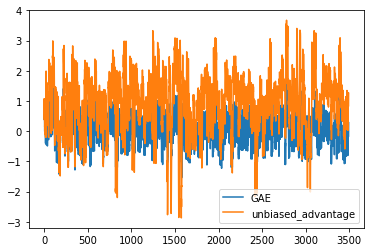

1


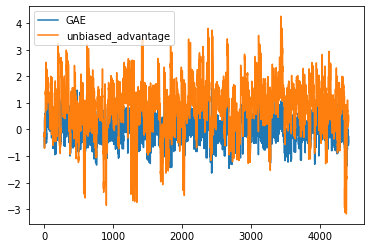

2


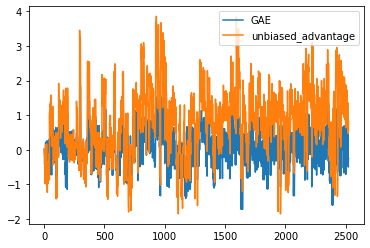

3


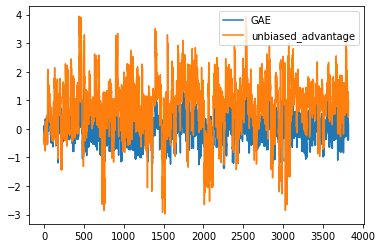

4


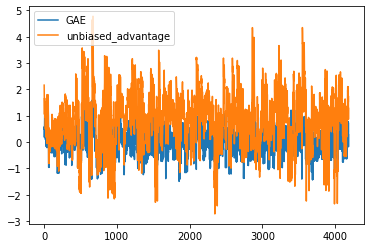

5


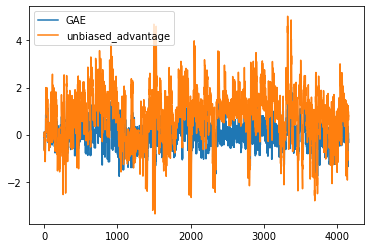

6


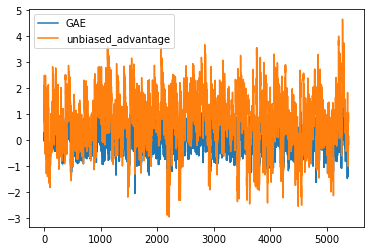

7


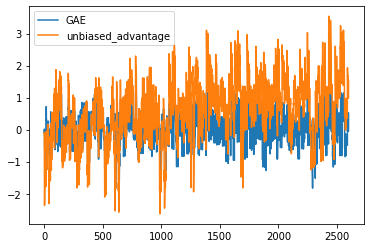

8


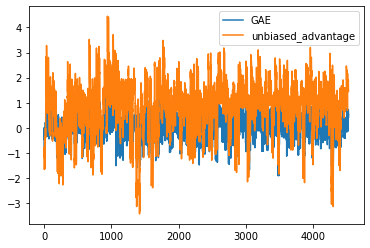

9


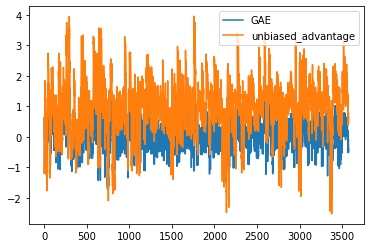

nstep: 16	time elapsed: 13s


In [43]:
FLAG_LEARN_VPI = True
value_features = tabular_features
policy_features = tabular_features

tic = time.time()
exp_data1 = dict()
print('Starting the experiments. Estimated time to completion: 1000 seconds')
for nstep in nstep_list: 
    print("nstep: {}".format(nstep))
    exp_data1[nstep] = dict()
    for stepsize in stepsize_list:
        policy_stepsize = stepsize
        value_stepsize = stepsize

        dat = run_experiment(num_runs, num_episodes,
                             P, r, start_state, terminal_states,
                             num_actions, policy_features, value_features,
                             policy_stepsize, value_stepsize, nstep, lambda_, gamma, 
                             FLAG_BASELINE, FLAG_LEARN_VPI, reward_noise)
        
        exp_data1[nstep][stepsize] = dat
    print('nstep: {}\ttime elapsed: {:.0f}s'.format(nstep, time.time() - tic)) 